# DH-401: Digital Musicology semester project
---------------
## Predicting music popularity using DNNs - Milestone 3

### Table of Content

1. [Popularity score](#pop)
    1. [Popularity features](#pop-feat)
    1. [Removing songs without album](#pop-remove) 
    1. [Computing popularity scores](#pop-scores)
1. [Features selection for regression](#feat-selection)
1. [Samples for questionnary](#survey)

-------------------

In [1]:
from zipfile import ZipFile
from tqdm.notebook import tqdm

from IPython import display
import librosa

import seaborn as sns
import pandas as pd
import ast

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import numpy as np

from scipy.stats import chisquare
from scipy.stats import shapiro

import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc
from sklearn import preprocessing


plt.rcParams['figure.figsize'] = (17, 5)


datasource = "data"
#datasource = "/content/drive/MyDrive"

In [2]:
# Load metadata and features.
# Function based on: https://github.com/mdeff/fma/blob/master/utils.py
tracks = pd.read_csv(f'{datasource}/fma_metadata/tracks.csv', index_col=0, header=[0, 1])

COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
            ('track', 'genres'), ('track', 'genres_all')]
for column in COLUMNS:
    tracks[column] = tracks[column].map(ast.literal_eval)

COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
            ('album', 'date_created'), ('album', 'date_released'),
            ('artist', 'date_created'), ('artist', 'active_year_begin'),
            ('artist', 'active_year_end')]
for column in COLUMNS:
    tracks[column] = pd.to_datetime(tracks[column])

SUBSETS = ('small', 'medium', 'large')
try:
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
            'category', categories=SUBSETS, ordered=True)
except (ValueError, TypeError):
    # the categories and ordered arguments were removed in pandas 0.25
    tracks['set', 'subset'] = tracks['set', 'subset'].astype(
              pd.CategoricalDtype(categories=SUBSETS, ordered=True))

COLUMNS = [('track', 'genre_top'), ('track', 'license'),
            ('album', 'type'), ('album', 'information'),
            ('artist', 'bio')]
for column in COLUMNS:
    tracks[column] = tracks[column].astype('category')


tracks.shape

(106574, 52)

## Popularity score  <a class="anchor" id="pop"></a>

The dataset contains different measures that can be used to define popularity: number of listens, likes and comments. These features are present at two levels (song and album). The two levels come from Free Music Archive's API and both encompass important information concerning the dispersion of the songs. Thus, we first build a DataFrame containing all these scores for all of the songs available in the dataset.

### Popularity features <a class="anchor" id="pop-feat"></a>

In [3]:
POP_FEATURES = ["listens", "favorites", "comments"]

In [4]:
pop_df = tracks["track"][["date_created", "genre_top"]+POP_FEATURES]

# add informations collected at the "album level"
for pop_feat in POP_FEATURES:
    pop_df["album_"+pop_feat] = [count for count in tracks["album"][pop_feat]]

pop_df.sample(3)

,date_created,genre_top,listens,favorites,comments,album_listens,album_favorites,album_comments
track_id,,,,,,,,
11564,2009-04-28 01:20:57,NaN,382,1,0,4634,0,0
92738,2013-10-28 12:04:59,NaN,37276,175,0,297933,2,0
70302,2012-09-25 07:35:15,Electronic,14217,27,1,61975,4,1


The number of listens per song and per album reflect different realities, in that they are not directly based on one another (the number of listens of an album is not the sum of the number of listens of its songs and the number of listens of the songs don't take into account the number of listens of the album). In other words, if $l_s$ is the number of listens of a song, $a$ refers to albums and $\{s\in a\}$ the set of songs in one album, $$ \sum_{s\in a}l_s \neq l_a $$

This fact is illustrated below and two extreme examples are underlined.

In [5]:
# build a DataFrame of albums
albums = tracks["album"].groupby(["id"]).mean()[["listens"]]
# remove songs without album
albums = albums[albums.listens > 0]

albums["sum_songs"] = 0
albums["album"] = 0
albums["songs_minus_album"] = 0
albums["songs_ratio_album"] = 0

for alb_id, _ in tqdm(albums.iterrows(), total=albums.shape[0]):
    # retrieve track ids for the album
    curr_track_ids = tracks["album"][tracks["album"].id == alb_id].index.values
    # compute sum of the listens of the album's songs
    curr_sum_songs_listens = pop_df.loc[curr_track_ids].listens.sum()
    # retrieve album's number of listens
    curr_album_listens = pop_df.loc[curr_track_ids].album_listens.iloc[0]
    
    # add these information to the `albums` DataFrame
    albums.loc[alb_id, "sum_songs"] = curr_sum_songs_listens
    albums.loc[alb_id, "album"] = curr_album_listens
    # compute difference and ratio
    albums.loc[alb_id, "songs_minus_album"] = curr_sum_songs_listens-curr_album_listens
    albums.loc[alb_id, "songs_ratio_album"] = curr_sum_songs_listens/curr_album_listens
    
albums = albums.sort_values(by="songs_minus_album")

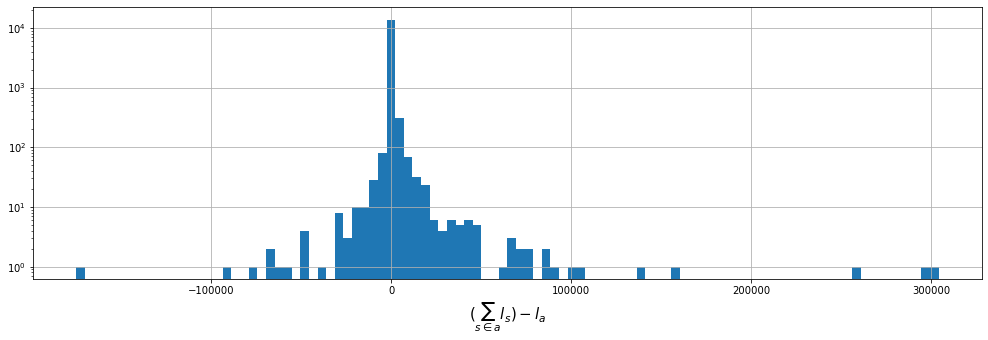

In [6]:
# histogram of the sum of album's songs' listens - album's listens
albums["songs_minus_album"].hist(bins=100)
plt.xlabel(r"$(\sum_{s\in a}l_s) - l_a$", fontsize=15)
plt.semilogy()
plt.show()

In [7]:
id_album = albums["songs_minus_album"].idxmin() #10953

id_tracks = tracks["album"][tracks["album"].id == id_album].index.values

print("The album '{album_title}' containing {n_songs} song{plural} was listened {alb_listens} times as an album, \
but individually the song{plural} account{sing} for {more_or_less} listens: {songs_sum_listens}."\
      .format(album_title=tracks["album"].loc[id_tracks].iloc[0].title
              , n_songs=len(id_tracks)
              , plural='s' if len(id_tracks)>1 else ''
              , sing='' if len(id_tracks)>1 else 's'
              , alb_listens=pop_df.loc[id_tracks].iloc[0].album_listens
              , songs_sum_listens=np.sum(pop_df.loc[id_tracks].listens)
              , more_or_less='more' 
              if (np.sum(pop_df.loc[id_tracks].listens)/pop_df.loc[id_tracks].iloc[0].album_listens)>1 
              else 'less'
             )
     )

The album 'Music For Media Vol. 3' containing 8 songs was listened 247274 times as an album, but individually the songs account for less listens: 72202.


In [8]:
id_album = albums["songs_minus_album"].idxmax() #7690

id_tracks = tracks["album"][tracks["album"].id == id_album].index.values

print("The album '{album_title}' containing {n_songs} song{plural} was listened {alb_listens} times as an album, \
but individually the song{plural} account{sing} for {more_or_less} listens: {songs_sum_listens}."\
      .format(album_title=tracks["album"].loc[id_tracks].iloc[0].title
              , n_songs=len(id_tracks)
              , plural='s' if len(id_tracks)>1 else ''
              , sing='' if len(id_tracks)>1 else 's'
              , alb_listens=pop_df.loc[id_tracks].iloc[0].album_listens
              , songs_sum_listens=np.sum(pop_df.loc[id_tracks].listens)
              , more_or_less='more' 
              if (np.sum(pop_df.loc[id_tracks].listens)/pop_df.loc[id_tracks].iloc[0].album_listens)>1 
              else 'less'
             )
     )

The album '...Plays Guitar' containing 7 songs was listened 386403 times as an album, but individually the songs account for more listens: 690479.


### Removing songs without album <a class="anchor" id="pop-remove"></a>

The number of listens, likes and comments of albums bring supplementary, non negligible, information about the public a song could have reached. However some songs don't appear in albums (reflected by $-1$ for album listens, comments, and favorites counts in the DataFrame). These songs represent appproximately 3.3% of the dataset, so they are left aside to be able to compute a more coherent popularity score based on both of the disposable levels.

In [9]:
# songs without albums have -1 as count for listens, favorites, comments
no_album = pop_df.album_listens < 0
print("{0:.2f}% songs have no album.".format(100*np.sum(no_album)/len(pop_df)))

3.31% songs have no album.


In [10]:
# keeping only songs with album informations
pop_df = pop_df[~no_album].copy()
pop_df.shape

(103045, 8)

The distribution of the logarithmic transform of the different features are plotted below, sshowing that they reflect different realities and justifying that the album level should not be neglected, as it appears to be largely used by FMA's users.

In [11]:
def log_transform(serie):
    """log transform for serie of non-negative values"""
    return np.log((serie)+1)

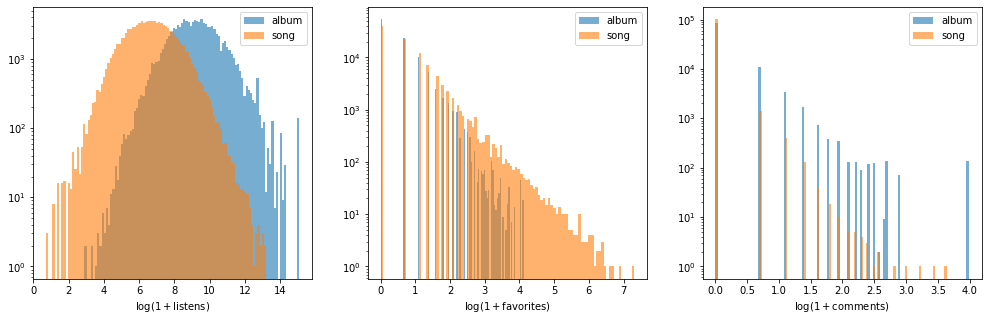

In [12]:
f, axes = plt.subplots(nrows=1,ncols=3, sharex=False)

for ax, feat in zip(axes, POP_FEATURES) :
    ax.hist(log_transform(pop_df["album_"+feat]), bins=100, alpha=0.6, label="album")
    ax.hist(log_transform(pop_df[feat]), bins=100, alpha=0.6, label="song")
    ax.set_xlabel(r"$\log(1+$"+feat+"$)$")
    ax.legend()
    ax.semilogy()
plt.legend()
plt.show()

### Computing popularity scores <a class="anchor" id="pop-scores"></a>

The popularity score can then be computed as the one-dimensional projection of the logarithmic transformation of these features using PCA to encompass the maximum informations of these different dimensions in a single value per song.

This popularity score can then be thought of as a proxy of the ability of a song to reach a great audience. The number of likes and comments add informations about the engagement of publics towards the songs.
It could potentially embrace social dynamics, an hypothesis could be that users that have liked or commented a song are more prone to recommend or play this song to their entourage, thus spreading the song.

In [13]:
# without `interest` but with album scores
X = pop_df[POP_FEATURES+["album_"+pop_feat for pop_feat in POP_FEATURES]].copy()

for pop_feat in X.columns:
    # using log transform for the pca
    X[pop_feat] = log_transform(X[pop_feat])

pca = PCA(n_components=1, svd_solver="full").fit(X)
#computing popularity score as a 1D projection of the popularity features
pop_df["pop_score"] = pca.transform(X) 

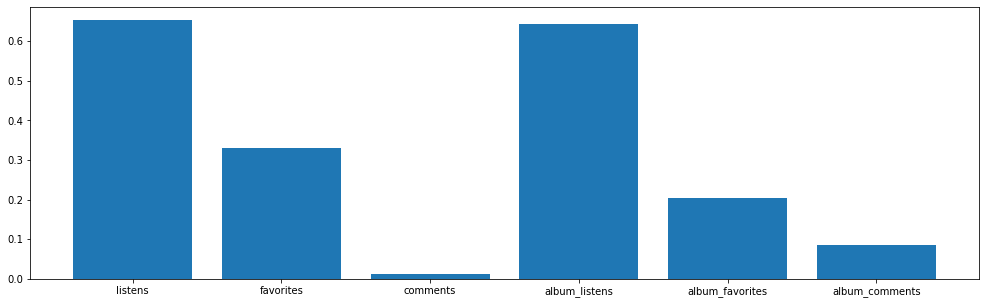

In [14]:
# display the weight of each component in the projection
plt.bar(X.columns
        , (pca.components_)[0]
       )
plt.show()

/Users/elisamichelet/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


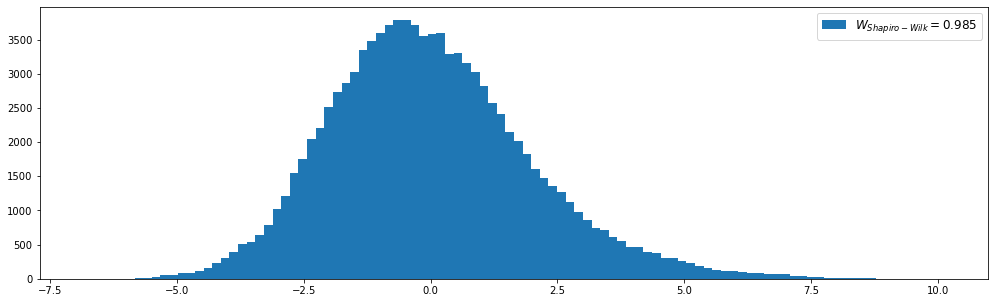

In [15]:
# plot the distribution of the 1D-popularity projection, and showcase its Shapiro-Wilk score
W, p_val = shapiro(pop_df.pop_score)

plt.hist(pop_df.pop_score, bins=100, label=r"$W_{Shapiro-Wilk}"+"={0:.3f}$".format(W))
plt.legend(fontsize=12)
plt.show()

In [16]:
# as the distribution is ~ normal (shapiro close to 1), standardize the score (z-score normalization)
pop_df["pop_score"] = (pop_df["pop_score"]-np.mean(pop_df["pop_score"]))/(np.std(pop_df["pop_score"]))

In [17]:
pop_df.sample(3)

,date_created,genre_top,listens,favorites,comments,album_listens,album_favorites,album_comments,pop_score
track_id,,,,,,,,,
108345,2014-08-17 12:25:46,NaN,5357,4,0,108493,1,1,1.576117
138318,2016-06-02 14:54:09,Rock,2771,0,0,30671,0,0,0.583065
152036,2017-02-12 07:55:51,Electronic,34,0,0,5153,0,0,-1.429750


## Generate samples for finetuning

In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pop_df.pop_score, test_size=0.05)
train.to_csv("train.csv")
test.to_csv("test.csv")

## Feature selection for regressions <a class="anchor" id="feat-selection"></a>

Correlation for each feature

In [19]:
features = pd.read_csv(f'{datasource}/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
features.sample(3)

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
71147        -0.759324 -0.610204  0.014023 -0.366312 -0.525913 -0.592291   
35305        -0.381919 -0.140353 -0.047258  0.615069  0.652836  0.631763   
13134        -0.747065 -0.924841  0.587429  1.198912  0.109523  0.395123   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
71147      -0.275986 -0.468058 -0.035632  0.726790  ...  0.110237  0.029942   
35305      -0.404351  0.538942 -0.222173  0.051932  ...  0.086809  0.011693   
13134      -0.072858  0.936795  0.167442 -0.618776  ...  0.090943  0.018951   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
71147       0.020062  13.681217  0.518555  0.053699  0.034668  0.000000   
35305       0.016150   2.643932  0.289551  0.060893  0.042480  0.002441   
13134       0.015733  -0.237352  0.560547  0.175151  0.156250  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
71147       3.322416  0.054976  
35305       1.768378  0.058092  
13134       0.745114  0.093765  

[3 rows x 518 columns]

In [20]:
corr_matrix = features.corr()

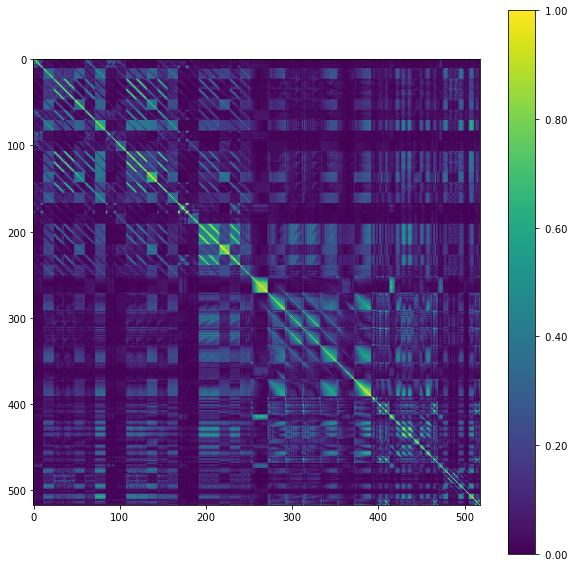

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(corr_matrix.abs())
im.set_clim(0, 1)
ax.grid(False)
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

Code from https://gist.github.com/MattJBritton/b6944218903312f6220bfb48706b593c#file-minimal_example-py

In [22]:
def visualize_feature_correlation(data, chart_type, target_name = None, cluster_scope = None, user_defined_clusters = None):
    df = data.copy()
    corr = np.round(df.corr(),2)
    if target_name is not None:
        target_corr = np.abs(corr.rename({target_name:"target_corr"}, axis=1)["target_corr"])
        df = df.drop(target_name, axis=1)
        corr = corr.drop(target_name, axis=1).drop(target_name, axis=0)
    default_feature_order = sorted(list(df.columns))
    corr_condensed = hc.distance.squareform(1 - np.abs(df.corr()) ) # convert to condensed
    z = hc.linkage(corr_condensed, method='average');
    feature_order = hc.dendrogram(z, labels=df.columns, no_plot=True)["ivl"];  
    if chart_type == "dendrogram":    
        fig = ff.create_dendrogram(
            1 - np.abs(corr), 
            labels = df.columns
        )
        fig.update_layout(width=800, height=500)
        fig.show()
    elif chart_type == "punchcard":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis=None),
            y = alt.Y("variable", sort = feature_order, axis=None)
        ).transform_calculate(
            abs_val = 'abs(datum.value)',
            positive_corr = 'datum.value > 0'
        ).transform_lookup(
            lookup='index',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_X", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_X']
            )
        ).transform_lookup(
            lookup='variable',
            from_=alt.LookupData(
                data=pd.DataFrame(feature_order).reset_index(drop=False).rename({"index":"order_Y", 0:"feature"}, axis=1),
                key='feature',
                fields=['order_Y']
            )
        ).properties(
            width = 700,
            height = 500
        )

        circles = base.mark_circle().encode(
            color = "positive_corr:N",
            size = alt.condition(
                "datum.order_Y >= datum.order_X",
                alt.value(0),
                alt.Size(
                    "abs_val:Q", 
                    scale=alt.Scale(range=[0,1000], domain=[0,1])
                )
            )
        )
        text = base.mark_text(align="right").encode(
            text = "index",
            opacity = alt.condition("datum.order_Y == datum.order_X", alt.value(1), alt.value(0))
        )
        return (text+circles).resolve_scale(y = "shared", x="shared")
    elif chart_type == "heatmap":
        heatmap_data = corr.reset_index(drop = False).melt(id_vars="index")
        base = alt.Chart(
            heatmap_data
        ).encode(
            x = alt.X("index", sort = feature_order, axis = alt.Axis(labelAngle=15)),
            y = alt.Y("variable", sort = feature_order)
        ).transform_calculate(
            abs_val = 'abs(datum.value)'
        ).properties(
            width = 600,
            height = 600
        )

        rects = base.mark_rect().encode(
            color = alt.Color("abs_val:Q", scale=alt.Scale(domain=[0,1])),
        )
        text = base.mark_text(align="center").encode(
            text = "value",
            color = alt.condition(
                "datum.value < .5",
                alt.value("black"),
                alt.value("white")
            )
        )
        return (rects+text).resolve_scale(y = "shared", x="shared")
    elif chart_type == "clusters":
        
        sidebar_width = 200
        sidebar_component_height = 75
        
        #compute PCA and store as X,Y coordinates for each feature
        pca = PCA(n_components = 2)
        pca.fit(np.abs(corr))
        pca_coords = pd.DataFrame.from_dict(
            dict(
                zip(
                    list(df.columns),
                    pca.transform(np.abs(corr)).tolist()
                )
            ),
            orient="index"
        ).reset_index().rename({0:"X", 1:"Y", "index":"feature"}, axis=1)
        
        

        if user_defined_clusters:
            
            num_labels = np.unique(user_defined_clusters.values()).shape[0]
            silhouette_scores = [
                {
                    "cluster_num": num_labels, 
                    "silhouette_score": 1, 
                    "feature": col,
                    "cluster": user_defined_clusters[col]
                }
                for col in df.columns
            ]
        else:
        
            #get feature clusters via another method
            scaler = StandardScaler()
            feature_distances = squareform(pdist(scaler.fit_transform(df).T, "euclidean"))
            silhouette_scores = []
            
            if cluster_scope is None:
                cluster_range = range(3,df.shape[1])
            elif isinstance(cluster_scope, int):
                cluster_range = range(cluster_scope, cluster_scope + 1)
            else:
                cluster_range = cluster_scope #range object
            for n_cluster in cluster_range:
                
                corr_clusters = FeatureAgglomeration(n_clusters = n_cluster, affinity = "precomputed", linkage = "average").fit(feature_distances)
                silhouette_scores = silhouette_scores\
                + [
                    {
                        "cluster_num": n_cluster,
                        "silhouette_score": silhouette_score(feature_distances, corr_clusters.labels_, metric = "precomputed"),
                        "feature": list(df.columns)[i],
                        "cluster": label 
                    }
                    for i, label in enumerate(corr_clusters.labels_)
                ]
        
        
        cluster_label_df = pd.DataFrame(silhouette_scores)
        cluster_label_df["cluster_size"] = cluster_label_df.groupby(["cluster_num", "cluster"])["feature"].transform("count")
        cluster_label_df["key"] = cluster_label_df["cluster_num"].astype(str).str.cat(cluster_label_df["feature"].astype(str), sep=":")
        
        cluster_label_df["cluster"] = cluster_label_df.groupby(["cluster_num","cluster"])["feature"].transform("first")
        
        default_cluster_num = cluster_label_df.groupby("cluster_num")["silhouette_score"].max().idxmax()

        # set correlation with target, if using, which determines circle size
        if target_name is not None:
            pca_coords = pca_coords.join(
                target_corr
            ).reset_index()
        else:

            pca_coords = pca_coords.reset_index()
            pca_coords["target_corr"] = 1

        # get dataset for lines between features (if they have higher correlation than corr_threshold)

        corr_lines = corr.reset_index(drop=False).rename({"index":"feature"}, axis=1)\
            .melt(id_vars = ["feature"], var_name = "feature_2", value_name = "corr")\
            .query("feature > feature_2")
        

        corr_lines["corr_abs"] = np.abs(corr_lines["corr"])
        corr_selector_data = corr_lines.copy()
        corr_selector_data["corr_abs"] = np.floor((corr_selector_data["corr_abs"]*10))/10
        corr_selector_data = corr_selector_data.groupby("corr_abs").size().reset_index().rename({0:"Count"}, axis = 1)
        corr_lines_1 = pd.merge(
            corr_lines, 
            pca_coords.loc[:,["feature", "X", "Y"]], 
            on = "feature"
        )
        corr_lines_2 = pd.merge(
            corr_lines, 
            pca_coords.set_index("feature").loc[:,["X", "Y"]],
            left_on = "feature_2", right_index = True
        )
        corr_lines = corr_lines_1.append(corr_lines_2)
        corr_lines["key"] = corr_lines["feature"] + corr_lines["feature_2"]
        
        

        corr_line_selector = alt.selection_single(fields = ["corr_abs"], init = {"corr_abs":0.7})
        cluster_num_selector = alt.selection_single(fields = ["cluster_num"], init = {"cluster_num":default_cluster_num})
        cluster_selection = alt.selection_single(fields=["cluster"])
        
        base = alt.layer().encode(
            x = alt.X("X", axis=None),
            y = alt.Y("Y", axis=None),
            color = alt.condition(
                cluster_selection,
                alt.Color("cluster:N", legend = None),
                alt.value("lightgray")
            )
        )
        
        base += alt.Chart(pca_coords).mark_circle().encode(
            size = alt.Size("target_corr:Q", scale=alt.Scale(domain = [0,1]), legend=None)
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        ).add_selection(
            cluster_num_selector
        )
        
        base += alt.Chart(pca_coords).mark_text(dx=20, dy = 10).encode(
            text = "feature",
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        )
        
        base += alt.Chart(corr_lines).mark_line().encode(
            detail = "key",
            strokeWidth = alt.StrokeWidth("corr_abs", scale = alt.Scale(domain = [0,1], range = [.3,3]))
        ).transform_filter(
            alt.datum.corr_abs >= corr_line_selector.corr_abs
        ).transform_calculate(
            key = cluster_num_selector.cluster_num + ":" + alt.datum.feature
        ).transform_lookup(
            lookup='key',
            from_=alt.LookupData(data=cluster_label_df, key='key',
                                 fields=['cluster_size', 'cluster'])            
        )
        
        base = base.properties(
            width = 800, 
            height = 500,
            title = "Feature Space Diagram"
        ).interactive()
        
        num_cluster_picker = alt.Chart(cluster_label_df).mark_bar().encode(
            y = alt.Y("silhouette_score", title = "Silhouette Score"),
            x = "cluster_num:O",
            color = alt.condition(
                cluster_num_selector, 
                alt.value("lightblue"), 
                alt.value("lightgray")
            )            
        ).add_selection(
            cluster_num_selector
        ).properties(
            width = sidebar_width,
            height = sidebar_component_height,
            title = "Select the Number of Clusters"
        )
        
        corr_threshold_picker = alt.Chart(corr_selector_data).mark_bar().encode(
            x = "corr_abs:O",
            y = alt.Y("Count", axis = alt.Axis(labelAngle = 0, title = "Feature Pairs")),
            color = alt.condition(
                alt.datum.corr_abs >= corr_line_selector.corr_abs, 
                alt.value("lightblue"), 
                alt.value("lightgray")
            )
        ).add_selection(
            corr_line_selector
        ).properties(
            width = sidebar_width,
            height = sidebar_component_height,
            title = "Select Correlation Threshold to Show Lines"
        )
        
        cluster_bar_chart = alt.Chart(cluster_label_df).mark_bar(size=5).encode(
            y = alt.Y(
                "cluster:N", 
                sort = alt.EncodingSortField(field = "cluster_size", order="descending"),
                title = None #  "Clusters"
            ),
            x = "cluster_size",
            color = alt.Color("cluster:N", legend=None),
        ).add_selection(
            cluster_selection
        ).transform_filter(
            (alt.datum.cluster_num >= cluster_num_selector.cluster_num) & (alt.datum.cluster_num <= cluster_num_selector.cluster_num)
        ).properties(
            width = sidebar_width,
            height = 200,
            title = "Cluster Sizes. Click to Highlight"
        )        
        return (base) | (num_cluster_picker & corr_threshold_picker & cluster_bar_chart)

In [23]:
features_flatten = features.copy()
features_flatten.columns = ['_'.join(col) for col in features.columns.values]

In [24]:
chroma = features[['chroma_stft', 'chroma_cqt', 'chroma_cens']]
chroma.columns = ['_'.join(col) for col in chroma.columns.values]

mfcc = features['mfcc']
mfcc.columns = ['_'.join(col) for col in mfcc.columns.values]

rmse = features['rmse']
rmse.columns = ['_'.join(col) for col in rmse.columns.values]

spectral = features[['spectral_contrast', 'spectral_rolloff', 'spectral_centroid', 'spectral_bandwidth']]
spectral.columns = ['_'.join(col) for col in spectral.columns.values]

tonnetz = features['tonnetz']
tonnetz.columns = ['_'.join(col) for col in tonnetz.columns.values]

zcr = features['zcr']
zcr.columns = ['_'.join(col) for col in zcr.columns.values]

TODO add correlation viz

In [25]:
selected_features = ['chroma_stft_mean_01', 'chroma_stft_std_01', 'chroma_cqt_kurtosis_03', 'chroma_stft_max_01', 'chroma_stft_kurtosis_01', 'chroma_stft_kurtosis_03', 'chroma_cqt_mean_01', 'chroma_cqt_mean_07','chroma_cqt_kurtosis_01', 'chroma_cqt_kurtosis_08']
selected_features = selected_features + ['mfcc_max_01', 'mfcc_max_05', 'mfcc_kurtosis_03', 'mfcc_min_04', 'mfcc_skew_09', 'mfcc_max_02', 'mfcc_max_03', 'mfcc_skew_04', 'mfcc_skew_03', 'mfcc_kurtosis_01']
selected_features = selected_features + ['rmse_max_01', 'rmse_kurtosis_01', 'rmse_min_01']
selected_features = selected_features + ['spectral_contrast_max_01', 'spectral_contrast_max_07', 'spectral_contrast_kurtosis_01', 'spectral_contrast_min_01', 'spectral_rolloff_kurtosis_01', 'spectral_contrast_max_06', 'spectral_rolloff_max_01', 'spectral_contrast_kurtosis_06', 'spectral_contrast_kurtosis_07', 'spectral_contrast_skew_07']
selected_features = selected_features + ['tonnetz_max_01', 'tonnetz_kurtosis_01', 'tonnetz_mean_02', 'tonnetz_min_01', 'tonnetz_mean_01', 'tonnetz_mean_03', 'tonnetz_skew_03', 'tonnetz_skew_04', 'tonnetz_skew_05', 'tonnetz_skew_06']

In [26]:
df_selected_features = features_flatten[selected_features]
x = df_selected_features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_selected_features_normalized = pd.DataFrame(x_scaled)

In [27]:
df_selected_features_normalized.index = tracks["track"]['genre_top'].index
df_selected_features_normalized = df_selected_features_normalized[df_selected_features_normalized.index.isin(pop_df["pop_score"].index)]
X = df_selected_features_normalized
y =  pop_df["pop_score"]

In [28]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pop_score   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     135.1
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        14:01:06   Log-Likelihood:            -1.4339e+05
No. Observations:              103045   AIC:                         2.869e+05
Df Residuals:                  103001   BIC:                         2.873e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9925      0.530      7.528      0.000       2.953       5.032
0             -0.1023      0.031     -3.353      0.001      -0.162      -0.042
1              0.3910      0.038     10.241      0.000       0.316       0.466
2             -1.7740      0.490     -3.617      0.000      -2.735      -0.813
3             -1.0914      0.485     -2.253      0.024      -2.041      -0.142
4             -0.9342      0.962     -0.971      0.331      -2.819       0.951
5              0.6150      0.587      1.048      0.294      -0.535       1.765
6             -0.5904      0.029    -20.430      0.000      -0.647      -0.534
7             -0.6721      0.028    -24.160      0.000      -0.727      -0.618
8              0.2975      0.946      0.314      0.753      -1.556       2.151
9             -2.4952      0.757     -3.298      0.001      -3.978      -1.012
10             0.4276      0.076      5.594      0.000       0.278       0.577
11            -1.3332      0.041    -32.821      0.000      -1.413      -1.254
12            -1.6097      0.306     -5.257      0.000      -2.210      -1.010
13             0.1920      0.035      5.445      0.000       0.123       0.261
14            -0.4031      0.125     -3.226      0.001      -0.648      -0.158
15             0.2963      0.048      6.227      0.000       0.203       0.390
16             1.1787      0.036     32.509      0.000       1.108       1.250
17            -1.7490      0.127    -13.763      0.000      -1.998      -1.500
18            -2.2799      0.092    -24.818      0.000      -2.460      -2.100
19            -0.4638      0.527     -0.881      0.379      -1.496       0.568
20            -0.1146      0.031     -3.700      0.000      -0.175      -0.054
21            -2.2557      0.770     -2.928      0.003      -3.766      -0.746
22             0.5682      0.270      2.101      0.036       0.038       1.098
23            -0.2043      0.032     -6.365      0.000      -0.267      -0.141
24            -0.1783      0.035     -5.144      0.000      -0.246      -0.110
25            -2.0996      0.605     -3.468      0.001      -3.286      -0.913
26             0.4884      0.037     13.036      0.000       0.415       0.562
27             1.4398      0.335      4.304      0.000       0.784       2.096
28            -0.0729      0.024     -3.074      0.002      -0.119      -0.026
29            -0.0052      0.034     -0.152      0.879      -0.072       0.061
30             0.2488      0.417      0.597      0.550      -0.568       1.066
31            -1.3787      0.107    -12.888      0.000      -1.588      -1.169
32            -0.5108      0.061     -8.429      0.000      -0.630      -0.392
33            -0.1981      0.044     -4.461      0.000      -0.285      -0.111
34            -0.3390      0.255     -1.332      0.183      -0.838       0.160
35

In [29]:
coeffs_results = results.params
pvalues_results = results.pvalues
coeffs_results.index = ['intercept'] + selected_features
pvalues_results.index = ['intercept'] + selected_features
coeffs_results[pvalues_results < 0.05].sort_values()

chroma_cqt_kurtosis_08          -2.495228
mfcc_skew_03                    -2.279891
rmse_kurtosis_01                -2.255653
spectral_contrast_kurtosis_01   -2.099599
chroma_cqt_kurtosis_03          -1.773952
mfcc_skew_04                    -1.749003
mfcc_kurtosis_03                -1.609724
spectral_contrast_kurtosis_07   -1.378706
mfcc_max_05                     -1.333245
chroma_stft_max_01              -1.091432
chroma_cqt_mean_07              -0.672139
chroma_cqt_mean_01              -0.590365
spectral_contrast_skew_07       -0.510810
tonnetz_skew_06                 -0.496266
tonnetz_skew_03                 -0.415611
mfcc_skew_09                    -0.403052
spectral_contrast_max_01        -0.204281
tonnetz_max_01                  -0.198128
spectral_contrast_max_07        -0.178251
tonnetz_mean_03                 -0.121386
rmse_max_01                     -0.114562
chroma_stft_mean_01             -0.102282
spectral_contrast_max_06        -0.072909
tonnetz_min_01                   0

### By genre

In [30]:
X = df_selected_features_normalized
genres = tracks["track"].groupby('genre_top').count()['number'].index.tolist()

In [31]:
def find_predictors(genre, p_val):
    X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
    y =  pop_df["pop_score"][tracks['track']['genre_top'] == genre]

    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    coeffs_results = results.params
    pvalues_results = results.pvalues
    if len(coeffs_results.index) > len(selected_features) :
        coeffs_results.index = ['const'] + selected_features
        pvalues_results.index = ['const'] + selected_features
    else :
        coeffs_results.index = selected_features
        pvalues_results.index = selected_features
    return coeffs_results[pvalues_results < p_val].sort_values()

In [32]:
preds = [{g : find_predictors(g, 0.05).to_dict()} for g in genres]

<ipython-input-31-146b8061075c>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = df_selected_features_normalized[tracks["track"]['genre_top'] == genre]
/Users/elisamichelet/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [33]:
df_merged = pd.DataFrame()
for p in preds:
    df_merged = df_merged.merge(pd.DataFrame(p), left_index=True, right_index=True, how='outer')

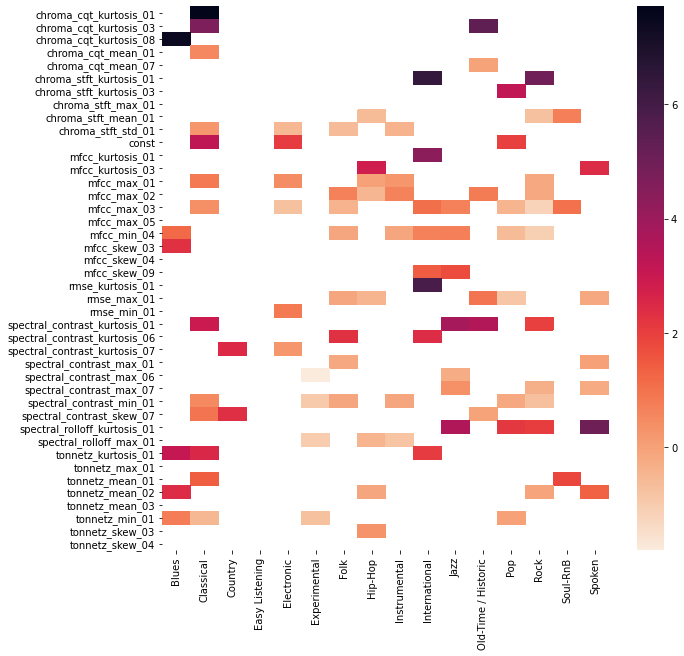

In [34]:
import seaborn as sns;

# Effect of positive coeffs
df_merged_pos = df_merged[df_merged>0]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(np.log(df_merged_pos), cmap=sns.cm.rocket_r, ax=ax)

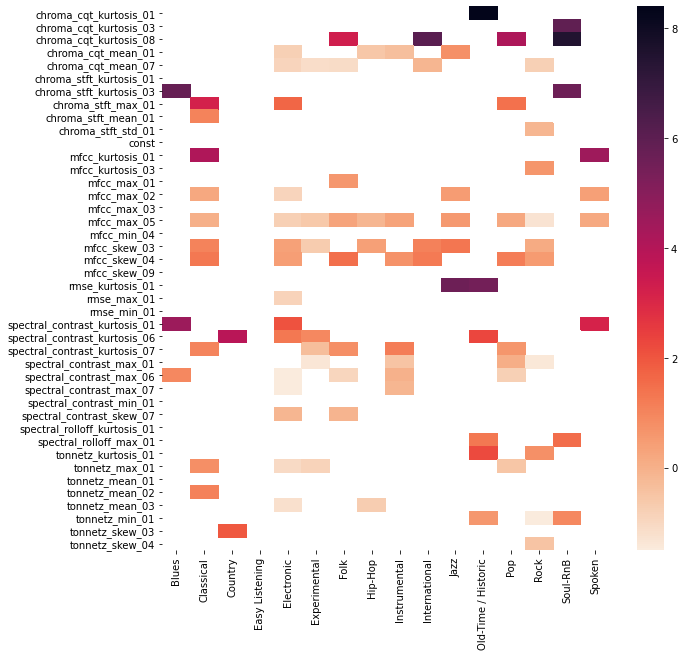

In [35]:
# Effect of negative coeffs
df_merged_neg = df_merged[df_merged<0]

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(np.log(abs(df_merged_neg)), cmap=sns.cm.rocket_r, ax=ax)

## Samples for questionnary <a class="anchor" id="survey"></a>

In [36]:
min_max_scaler = preprocessing.MinMaxScaler()
feature_flatten_normalized = min_max_scaler.fit_transform(features_flatten)
feature_flatten_normalized = pd.DataFrame(feature_flatten_normalized)
feature_flatten_normalized.columns = features_flatten.columns
feature_flatten_normalized.index = features_flatten.index
feature_flatten_normalized.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.001033,0.002501,0.001246,0.001021,0.001067,0.000873,0.000798,0.001470,0.003169,0.002444,...,0.148243,0.130829,0.101443,0.000915,0.454097,0.097468,0.079564,0.000000,0.189929,0.143937
3,0.000435,0.000941,0.001300,0.001243,0.001121,0.000708,0.000771,0.001047,0.002547,0.002038,...,0.177944,0.152235,0.150073,0.000568,0.461007,0.096271,0.071390,0.000000,0.185952,0.162532
5,0.000281,0.000649,0.000948,0.000865,0.001210,0.000997,0.000236,0.000535,0.003005,0.002274,...,0.107253,0.135841,0.124322,0.001040,0.368707,0.060433,0.046322,0.000000,0.191032,0.104805
10,0.000640,0.000574,0.002340,0.000649,0.001031,0.001039,0.000865,0.001189,0.002886,0.002806,...,0.210157,0.192545,0.117085,0.002773,0.446693,0.088225,0.080109,0.000000,0.205412,0.095226
20,0.000199,0.000606,0.001219,0.000765,0.000845,0.000714,0.000384,0.000564,0.002495,0.001236,...,0.273332,0.241482,0.181304,0.002208,0.464462,0.053726,0.044687,0.003724,0.201654,0.072089


In [44]:
def n_samples_genre(n, genre, high_score_threshold, low_score_threshold):
    print('Genre : ', genre)
    features_genre_relevant = feature_flatten_normalized[tracks["track"]['genre_top'] == genre][df_merged.index[df_merged.index != 'const']]
    mult = features_genre_relevant * df_merged['Blues']
    pop_score_pred = mult.sum(axis=1) 
    
    # True Positive
    tp = pop_score_pred[~no_album][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] > high_score_threshold].nlargest(n)
    print('TP')
    print(tp)
    
    # False Positive
    fp = pop_score_pred[~no_album][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] > high_score_threshold].nsmallest(n)
    print('FP')
    print(fp)
    
    # True Negative
    tn = pop_score_pred[~no_album][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] < low_score_threshold].nlargest(n)
    print('TN')
    print(tn)
    
    # False Negative
    fn = pop_score_pred[~no_album][pop_df["pop_score"][tracks["track"]['genre_top'] == genre] < low_score_threshold].nsmallest(n)
    print('FN')
    print(fn)
    print("===============")
    
    return [tp, fp, tn, fn]

In [45]:
samples = []
#genres_survey = tracks["track"]['genre_top'].value_counts().index
genres_survey = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

for genre in genres_survey:
    samples.extend(n_samples_genre(1, genre, 2, 0))

Genre :  Electronic
TP
track_id
55186    19.898574
dtype: float64
FP
track_id
71514    11.259045
dtype: float64
TN
track_id
1332    26.44067
dtype: float64
FN
track_id
7022   -13.31611
dtype: float64
Genre :  Experimental
TP
track_id
38879    17.650502
dtype: float64
FP
track_id
44802    11.158338
dtype: float64
TN
track_id
63318    942.132315
dtype: float64
FN
track_id
30123   -119.179934
dtype: float64
Genre :  Folk
TP
track_id
131900    15.905286
dtype: float64
FP
track_id
131898    13.289876
dtype: float64
TN
track_id
38373    124.13102
dtype: float64
FN
track_id
38370    8.433269
dtype: float64
Genre :  Hip-Hop
TP
track_id
24425    17.963839
dtype: float64
FP
track_id
24429    11.749757
dtype: float64
TN
track_id
80296    22.039673
dtype: float64
FN
track_id
13736    11.782104
dtype: float64
Genre :  Instrumental
TP
track_id
112697    18.157554
dtype: float64
FP
track_id
97285    10.566454
dtype: float64
TN
track_id
109606    19.236739
dtype: float64
FN
track_id
10239   -190.16707

## Samples creation helper

In [ ]:
import shutil
samples = [str(sample).zfill(6) for sample in samples]

for sample in samples:
  shutil.copyfile(f"/content/drive/MyDrive/musicology-dataset/fma_large/{sample[0:3]}/{sample}.mp3", f"/content/drive/MyDrive/survey_samples/{sample}.mp3")

# Wav2Vec2.0 for popularity estimation

## Install the transformers and load the data ingestion classes we got from the training pipeline

In [29]:
!pip install transformers torchaudio

     |████████████████████████████████| 2.1MB 7.5MB/s 
     |████████████████████████████████| 1.9MB 37.5MB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 


## Loading the dataset

In [92]:
from tqdm import tqdm
import torch
import torchaudio
from transformers import Wav2Vec2FeatureExtractor
import torch.nn.functional as F


feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, max_length=480000)
min_train = -3.3939661205367715
max_train = 5.098214985136099

class PopularityDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        track_id = str(int(row.track_id)).zfill(6)
        audio_sample, _ = torchaudio.load(f"/content/drive/MyDrive/musicology-dataset-downsampled/{track_id}.mp3")
        audio_sample = torch.mean(audio_sample, dim=0, keepdim=True)
        audio_sample = audio_sample.squeeze().numpy()
        audio_sample = feature_extractor(audio_sample, sampling_rate=16000, return_tensors="pt", padding='max_length', max_length=480000).input_values
        #score = (row.pop_score - min_train)/(max_train-min_train)
        return {
            "input_ids": audio_sample.flatten()[:480000],
            "labels": torch.tensor(row.pop_score).float(),
        }

# Ensure we are using the same split as the one used for finetuning
test = pd.read_csv("https://mbien-public.s3.eu-central-1.amazonaws.com/dh-401/pop_test.csv")

test_ds = PopularityDataset(test[:10])
test.head()

,track_id,pop_score
0,147246,0.361502
1,15577,-0.022418
2,127407,-0.745016
3,131643,1.275226
4,116637,-0.683588


## Setup model architecture and load it from the hub
Only difference compared to the training code is no Dropout

In [90]:
import torch.nn as nn
from transformers import Wav2Vec2PreTrainedModel, Wav2Vec2Model
from transformers.modeling_outputs import SequenceClassifierOutput


class Wav2Vec2ForAudioClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.wav2vec2 = Wav2Vec2Model(config)
        self.dropout = nn.Dropout(0)
        self.classifier = nn.Linear(768, 1)

        self.init_weights()

    def forward(self, input_ids):
        outputs = self.wav2vec2(
            input_ids,
            output_attentions=True,
            output_hidden_states=True
        )
        pooled_output = outputs.last_hidden_state[:,0,:]

        return self.classifier(pooled_output)

model = Wav2Vec2ForAudioClassification.from_pretrained("/content/drive/MyDrive/musicology-experiment-files/fma2vec-finetuned/checkpoint-30000").to("cuda")

In [91]:
from torch.utils.data import DataLoader

test_dl = DataLoader(test_ds)

for sample in test_dl:
    model.eval()
    out = model(sample["input_ids"].to("cuda"))
    print("Original:", sample["labels"].item(), "Predicted:", out)

Original: 0.3615018427371979 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.02241761051118374 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.7450163960456848 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 1.275226354598999 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.6835883855819702 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 0.2886952757835388 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -1.2600702047348022 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.020840361714363098 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: -0.7316892147064209 Predicted: tensor([[-0.1074]], device='cuda:0', grad_fn=<AddmmBackward>)
Original: 1.057540774345398 Predicted: tensor([[-0.1074]], device='cuda:0'

## Is this the most expensive mean calculation ever? Damn this model! WIP to get it learn more reasonably (classification probably). But might be that the data is just unpredictable...